In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 8.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.5

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

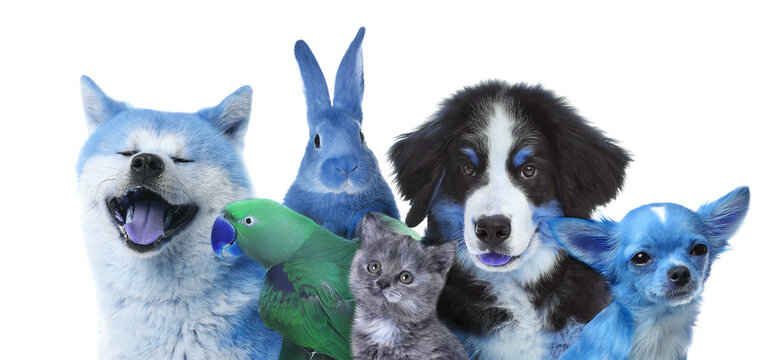

In [ ]:
# get the image
image=cv2.imread('/content/pet.jpg')
# Use cv2_imshow from google.colab.patches instead of cv2.imshow
from google.colab.patches import cv2_imshow
cv2_imshow(image[..., ::-1]) #bgr to rgb

**`Object Detection`**

In [ ]:
# create config-first get the config file
cfg=get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.5
cfg.MODEL.WEIGHTS=model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")



In [ ]:
predictor=DefaultPredictor(cfg)
outputs=predictor(image)


[09/29 17:23:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


model_final_f6e8b1.pkl: 243MB [00:01, 133MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([16, 16, 15, 15, 14, 16], device='cuda:0')
Boxes(tensor([[544.9510, 188.8585, 749.6821, 358.9957],
        [382.9876,  74.8253, 631.8836, 358.1373],
        [349.9510, 214.1756, 469.8541, 359.1317],
        [ 73.7527,  75.3698, 287.7914, 357.4683],
        [211.5405, 194.5621, 365.6873, 357.9357],
        [ 76.2867,  79.9050, 277.2570, 356.9908]], device='cuda:0'))


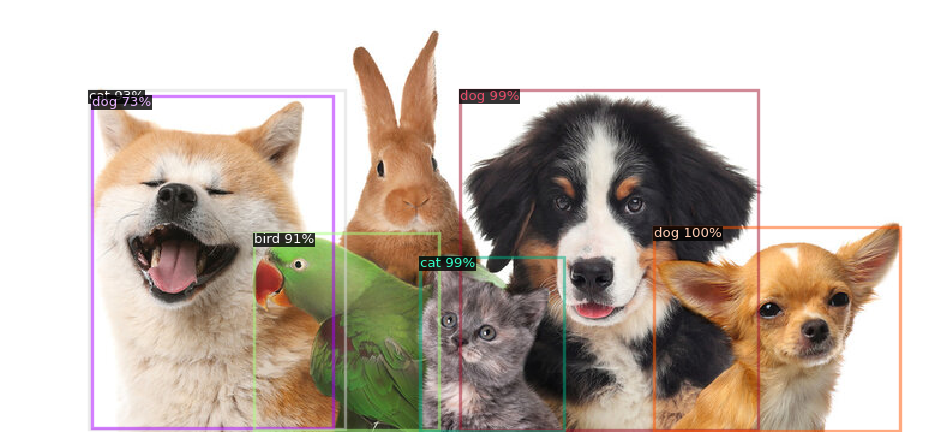

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

**`keypoint Detection:detecting pet and localizing their keypoints`**

[09/29 17:43:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


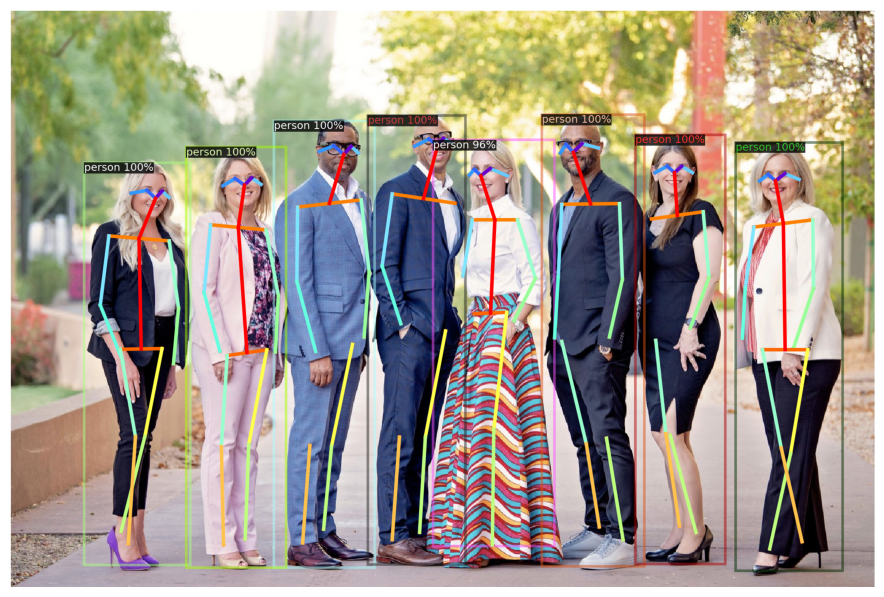

In [ ]:
# create config-first get the config file
import matplotlib.pyplot as plt
from PIL import Image

cfg=get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.7
cfg.MODEL.WEIGHTS=model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")


im=cv2.imread('/content/people.jpg')

def cv2_imshow(im):
  im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(25,7.5)),plt.imshow(im),plt.axis('off')
  plt.show()


predictor=DefaultPredictor(cfg)
outputs=predictor(im)


# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])


**`panoptic Segmentation model`**

[09/29 17:52:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:02, 125MB/s]                           


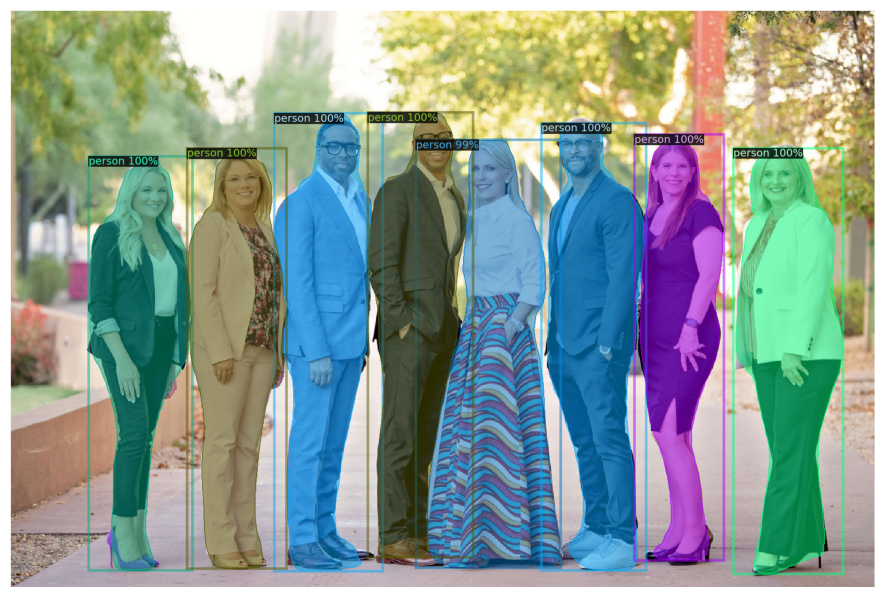

In [ ]:
# create config-first get the config file
import matplotlib.pyplot as plt
from PIL import Image

cfg=get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.7
cfg.MODEL.WEIGHTS=model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")


im=cv2.imread('/content/people.jpg')

def cv2_imshow(im):
  im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(25,7.5)),plt.imshow(im),plt.axis('off')
  plt.show()


predictor=DefaultPredictor(cfg)
outputs=predictor(im)


# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])


[09/29 17:54:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x/138363294/model_final_0464b7.pkl ...


model_final_0464b7.pkl: 766MB [00:13, 54.9MB/s]                           


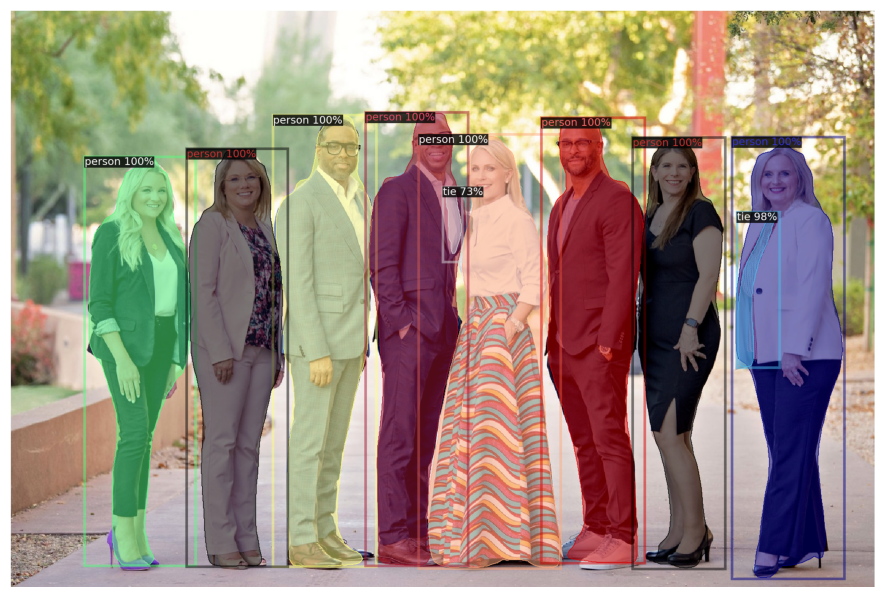

In [ ]:
# create config-first get the config file
import matplotlib.pyplot as plt
from PIL import Image

cfg=get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.7
cfg.MODEL.WEIGHTS=model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x.yaml")


im=cv2.imread('/content/people.jpg')

def cv2_imshow(im):
  im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(25,7.5)),plt.imshow(im),plt.axis('off')
  plt.show()


predictor=DefaultPredictor(cfg)
outputs=predictor(im)


# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])
